# 聚类空间

在本教程中，我们将探讨如何运行有监督的聚类，无监督的聚类以及摊销的潜在迪里奇分配（LDA）模型在`Omicverse`中使用高斯杂物，`Leiden/Louvain`和`Mira`。

在scRNA-seq数据分析中，我们通过发现与已知细胞状态或细胞周期阶段相关的细胞身份来描述数据集中的细胞结构。这个过程通常称为单元格标识注释。为此，我们将细胞结构成簇来推断相似细胞的身份。聚类本身就是一个常见的无监督机器学习问题。

LDA是最早在自然语言处理领域引入的一种主题建模方法。通过将每个细胞视为一个文件，将每个基因表达计数视为一个单词，我们可以将该方法推广到单细胞生物学领域。

下面，我们将在数据集上训练模型，在参考集的UMAP上绘制主题，并检查主题的特征基因集。

## 数据进行预处理

作为一个例子，我们应用微分动力学分析齿状回神经发生，它包括多个异质亚群。

Colab_Reproducibility：https://colab.research.google.com/drive/1d_szq-y-g7O0C5rJgK22XC7uWTUNrYpK?usp=sharing

In [1]:
import omicverse as ov
import scanpy as sc
import scvelo as scv
ov.plot_set()

/slurm/home/admin/.conda/envs/grns/lib/python3.11/site-packages/torch_geometric/typing.py:54: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /slurm/home/admin/.conda/envs/grns/lib/python3.11/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/slurm/home/admin/.conda/envs/grns/lib/python3.11/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /slurm/home/admin/.conda/envs/grns/lib/python3.11/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "



   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.5, Tutorials: https://omicverse.readthedocs.io/
All dependencies are satisfied.


In [4]:
import scvelo as scv
adata=scv.datasets.dentategyrus()
adata

AnnData object with n_obs × n_vars = 2930 × 13913
    obs: 'clusters', 'age(days)', 'clusters_enlarged'
    uns: 'clusters_colors'
    obsm: 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [5]:
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson', n_HVGs=3000,)
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]
ov.pp.scale(adata)
ov.pp.pca(adata,layer='scaled',n_pcs=50)

Begin robust gene identification
After filtration, 13264/13913 genes are kept. Among 13264 genes, 13189 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell. The following highly-expressed genes are not considered during normalization factor computation:
['Hba-a1', 'Malat1', 'Ptgds', 'Hbb-bt']
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
Time to analyze data in cpu: 2.719069719314575 seconds.
End of size normalization: shiftlog and HVGs selection pearson
... as `zero_center=True`, sparse input is densified and may lead to large mem

让我们检查单个pc对数据总方差的贡献。这给了我们关于为了计算单元的邻域关系我们应该考虑多少个pc的信息。根据我们的经验，通常粗略估计一下pc的数量就可以了。

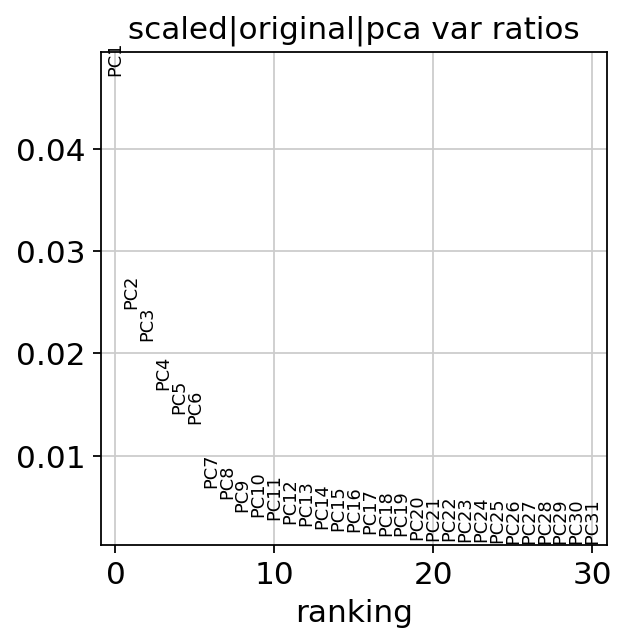

In [6]:
ov.utils.plot_pca_variance_ratio(adata)

## 无监督聚类

Leiden算法是Louvain算法的改进版本，在单细胞RNA-seq数据分析中优于其他聚类方法([Du et al.， 2018, Freytag et al.， 2018, Weber and Robinson, 2016])。由于不再维护Louvain算法，因此首选使用Leiden算法。

因此，我们建议在单细胞k近邻(KNN)图上使用Leiden算法[Traag等人，2019]来聚类单细胞数据集。

Leiden通过考虑集群中单元之间的链接数与数据集中总体预期的链接数来创建集群。

在这里，我们设置`method='leiden'`来使用`leiden`对单元进行聚类

In [7]:

sc.pp.neighbors(adata, 
                n_neighbors=15, 
                n_pcs=50, 
                use_rep='scaled|original|X_pca')
ov.utils.cluster(adata,method='leiden',resolution=1)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running Leiden clustering
    finished: found 24 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


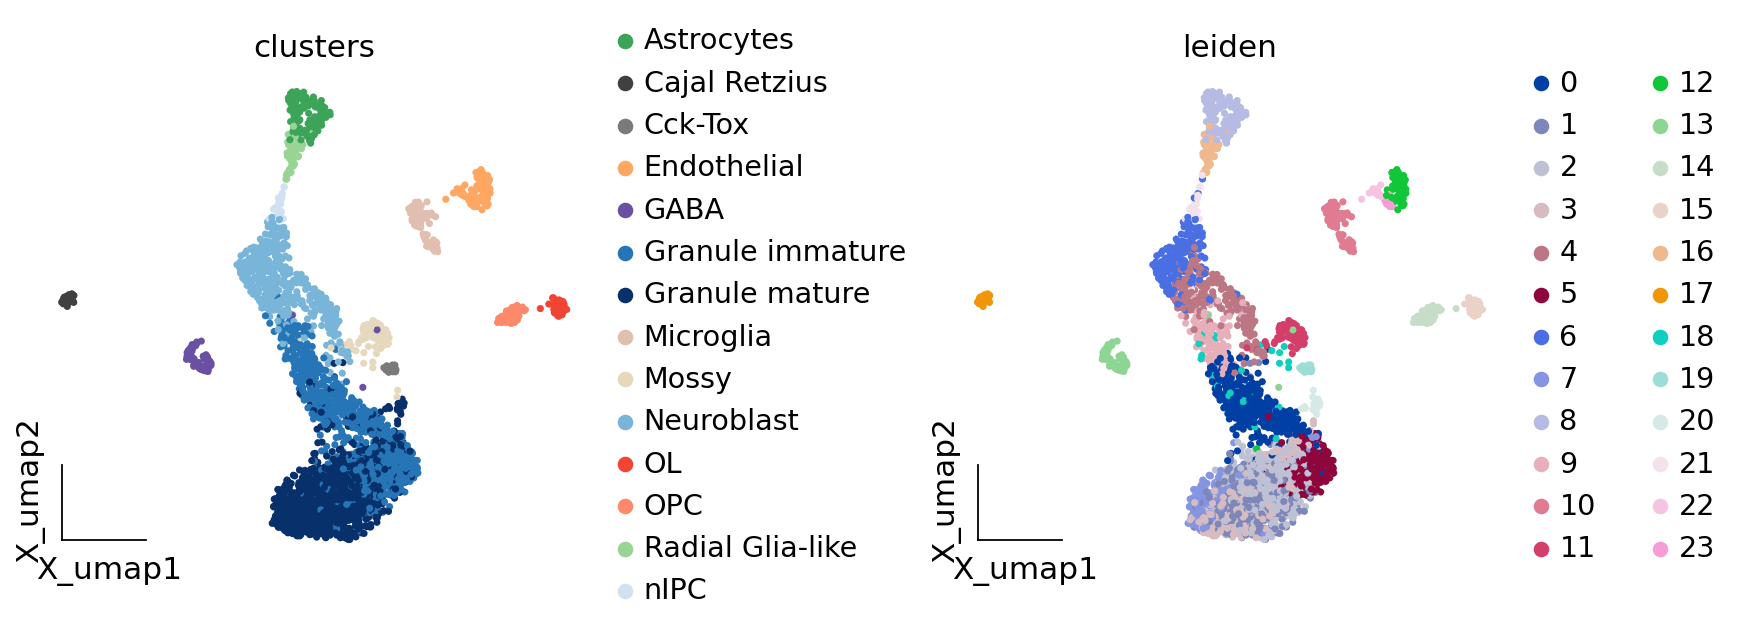

In [8]:
ov.utils.embedding(adata,basis='X_umap', color=['clusters','leiden'], frameon='small',wspace=0.5)

我们还可以设置`method='louvain'`来使用`louvain`对细胞进行聚类

In [13]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50,
               use_rep='scaled|original|X_pca')
ov.utils.cluster(adata,method='louvain',resolution=1)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 16 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


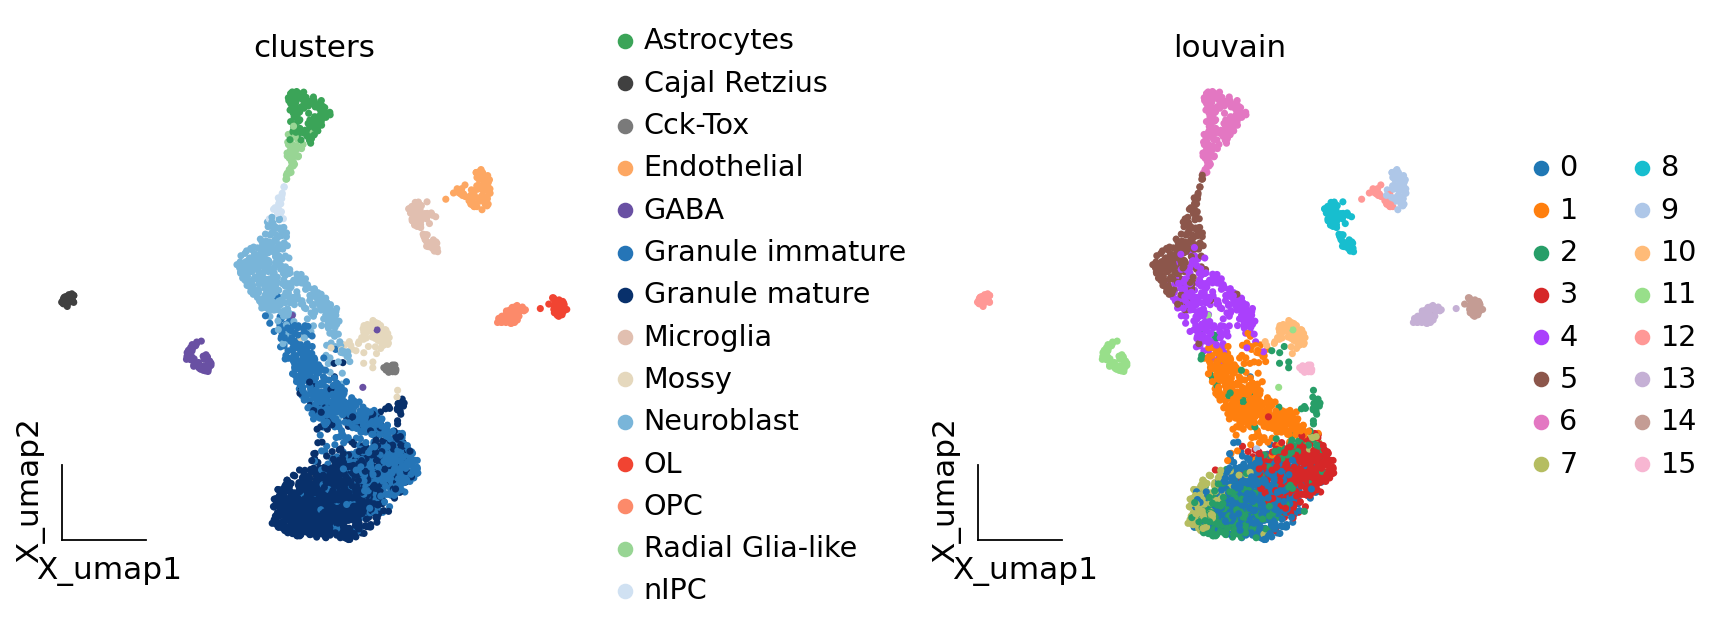

In [14]:
ov.utils.embedding(adata,basis='X_umap',
                   color=['clusters','louvain'],
                   frameon='small',wspace=0.5)

## 监督聚类
除了使用无监督聚类方法进行聚类之外，我们还可以尝试有监督聚类方法，例如高斯混合模型聚类，这是一种在机器学习中效果更好的监督聚类算法

高斯混合模型可以用与k-means大致相同的方式对未标记的数据进行聚类。然而，比起k-means，使用高斯混合模型也有一些优势。

首先，k-means不能解释方差。通过方差，我们指的是钟形曲线的宽度。

k-means和高斯混合模型的第二个区别是前者执行硬分类，而后者执行软分类。换句话说，k-means告诉我们哪个数据点属于哪个聚类，但不能提供给定数据点属于每个可能聚类的概率。

在这里，我们设置`method='GMM'`来使用`GaussianMixture`对单元进行聚类，n个分量表示要用于聚类的pc，协方差类型表示高斯混合模型(支持对角线、球面、绑定和全协方差矩阵)。更多的参数可以在`sklearn.mix.gaussianmixture`中找到

In [18]:
ov.utils.cluster(adata,use_rep='scaled|original|X_pca',
                 method='GMM',n_components=21,
                 modelNames='full')

running GaussianMixture clustering
finished: found 21 clusters and added
    'mclust', the cluster labels (adata.obs, categorical)


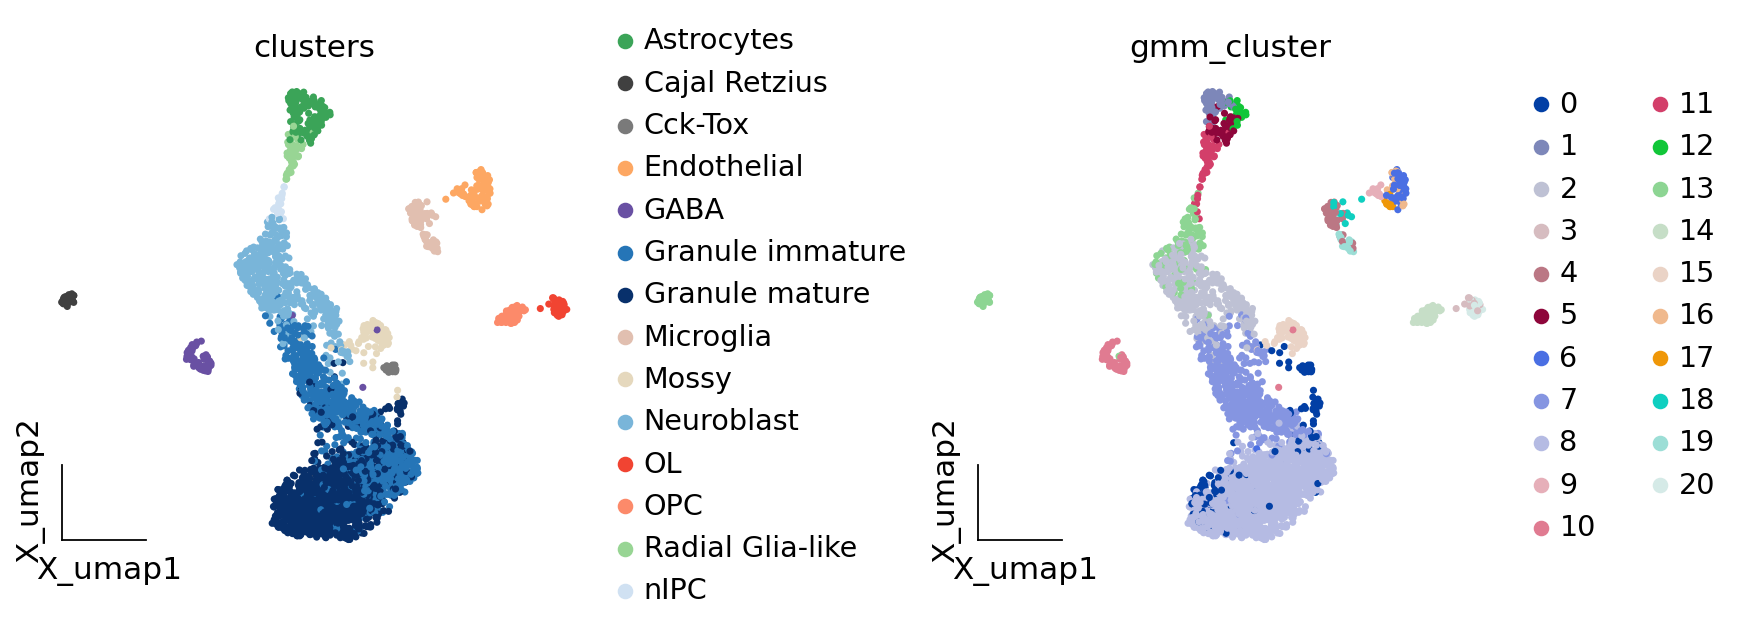

In [19]:
ov.utils.embedding(adata,basis='X_umap',
                   color=['clusters','gmm_cluster'],
                   frameon='small',wspace=0.5)

## 潜在狄利克雷分配(LDA)模型的实现
主题模型，如潜在狄利克雷分配(Latent Dirichlet Allocation, LDA)，传统上用于将文本语料库分解为主题(或主题)，这些主题由文档中经常一起出现的单词组成。反过来，根据文档包含的单词，将文档建模为主题的混合物。

MIRA将这些想法扩展到单细胞基因组学数据，其中主题是共表达的基因组或可共同访问的顺式调控元件，细胞是这些调控模块的混合物。

- feature_type: 我们使用什么类型的特性(表达式或可访问性)
- highly_variable_key: 哪个`.var`是找到高度可变基因的关键
- counts_layer: 从哪一层获取原始计数。
- categorical_covariates, continuous_covariates: 影响数据生成过程的技术变量。例如，一个分类的技术因素可能是细胞的原始批次，如下所示。一个连续的技术因素可能是%的线粒体读取。对于未批处理的数据，忽略这些参数。
- learning_rate: 对于较大的数据集，默认值为1e-3, 0.1通常效果很好。

In [22]:
LDA_obj=ov.utils.LDA_topic(adata,feature_type='expression',
                  highly_variable_key='highly_variable_features',
                 layers='counts',batch_key=None,learning_rate=1e-3)

mira have been install version: 0.9.23


AttributeError: module 'mira' has no attribute 'topics'

他的方法是通过实例化一个特殊版本的CODAL模型来实现的，这个模型有太多的主题，如果不需要描述数据，这些主题就会逐渐被删减。该函数返回每个主题对数据集中任何单元格的最大贡献。预测的主题数由最大贡献曲线的肘值减去1给出。经验法则是，在模型中包含的最后一个有效主题之后是一个下降，之后所有后续主题都在0.0 -0.05的最大贡献之间徘徊。

In [29]:
LDA_obj.plot_topic_contributions(6)

NameError: name 'LDA_obj' is not defined

我们可以观察到有13个主题高于阈值线，因此我们将新的NUM TOPIC设置为12

In [ ]:
LDA_obj.predicted(13)

可以绘制主题在细胞间的分布，以了解潜在空间如何反映细胞状态的变化

In [30]:
ov.plot_set()
ov.utils.embedding(adata, basis='X_umap',color = LDA_obj.model.topic_cols, cmap='BuPu', ncols=4,
           add_outline=True,  frameon='small',)


All dependencies are satisfied.


NameError: name 'LDA_obj' is not defined

KeyError: 'LDA_cluster'

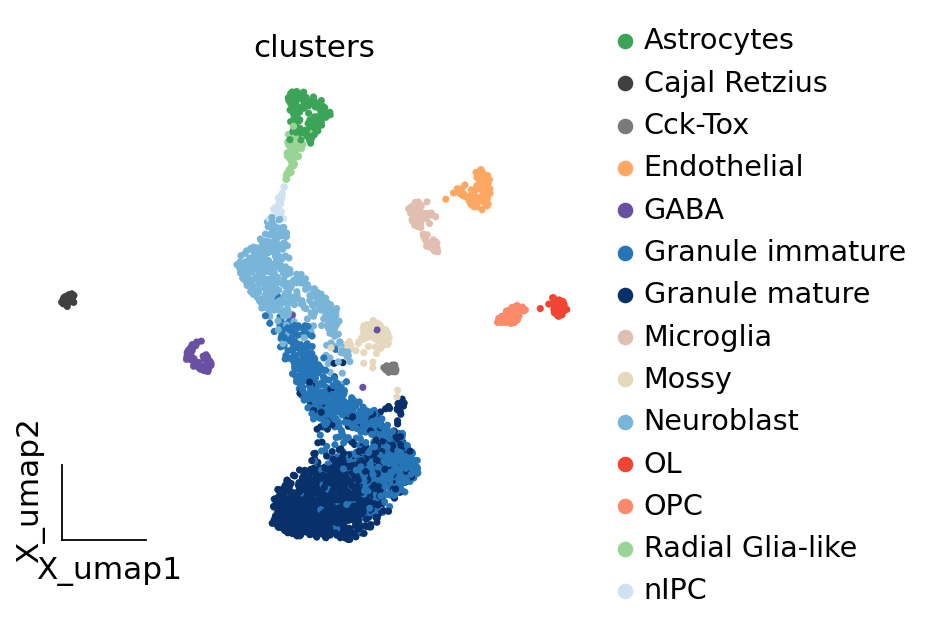

In [31]:
ov.utils.embedding(adata,basis='X_umap',
                   color=['clusters','LDA_cluster'],
                   frameon='small',wspace=0.5)

在这里，我们提出了另一个分类的想法。我们使用LDA大于0.4的细胞作为原始类，然后训练随机森林分类模型，然后使用随机森林分类模型对LDA小于0.5的细胞进行分类，以获得更准确的分类结果

In [32]:
LDA_obj.get_results_rfc(adata,use_rep='scaled|original|X_pca',
                        LDA_threshold=0.4,num_topics=13)

NameError: name 'LDA_obj' is not defined

In [33]:
ov.utils.embedding(adata,basis='X_umap',
                   color=['LDA_cluster_rfc','LDA_cluster_clf'],
                   frameon='small',wspace=0.5)

KeyError: 'LDA_cluster_rfc'

<Figure size 960x320 with 0 Axes>

## cNMF

可以在https://starlitnightly.github.io/omicverse/tutorials-single/t_cnmf/中找到更多详细信息

In [34]:
adata.X.toarray()


array([[5.9377255, 0.       , 0.       , ..., 8.609415 , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 7.206903 , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 8.979355 , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 8.287922 , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 8.657587 , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 9.004353 , 0.       ,
        5.02186  ]], dtype=float32)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


30it [00:08,  3.38it/s]


Combining factorizations for k=5.
Missing file: example_dg1/cNMF/dg_cNMF/cnmf_tmp/dg_cNMF.spectra.k_5.iter_1.df.npz. Skipping.
Missing file: example_dg1/cNMF/dg_cNMF/cnmf_tmp/dg_cNMF.spectra.k_5.iter_2.df.npz. Skipping.
Missing file: example_dg1/cNMF/dg_cNMF/cnmf_tmp/dg_cNMF.spectra.k_5.iter_3.df.npz. Skipping.
Missing file: example_dg1/cNMF/dg_cNMF/cnmf_tmp/dg_cNMF.spectra.k_5.iter_5.df.npz. Skipping.
Missing file: example_dg1/cNMF/dg_cNMF/cnmf_tmp/dg_cNMF.spectra.k_5.iter_6.df.npz. Skipping.
Missing file: example_dg1/cNMF/dg_cNMF/cnmf_tmp/dg_cNMF.spectra.k_5.iter_7.df.npz. Skipping.
Missing file: example_dg1/cNMF/dg_cNMF/cnmf_tmp/dg_cNMF.spectra.k_5.iter_9.df.npz. Skipping.
Missing file: example_dg1/cNMF/dg_cNMF/cnmf_tmp/dg_cNMF.spectra.k_5.iter_10.df.npz. Skipping.
Missing file: example_dg1/cNMF/dg_cNMF/cnmf_tmp/dg_cNMF.spectra.k_5.iter_11.df.npz. Skipping.
Missing file: example_dg1/cNMF/dg_cNMF/cnmf_tmp/dg_cNMF.spectra.k_5.iter_13.df.npz. Skipping.
Missing file: example_dg1/cNMF/dg

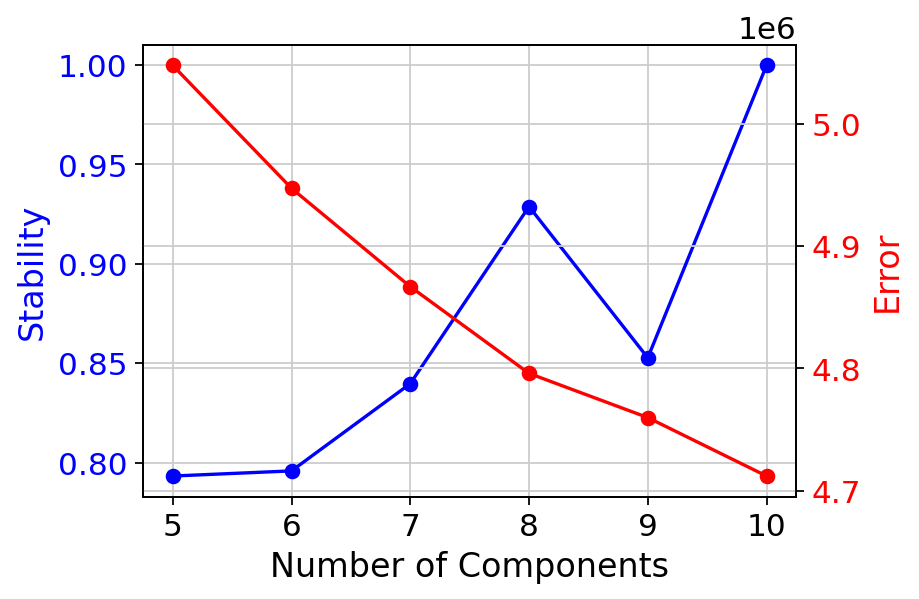

In [35]:
import numpy as np
## Initialize the cnmf object that will be used to run analyses
cnmf_obj = ov.single.cNMF(adata,components=np.arange(5,11), n_iter=20, seed=14, num_highvar_genes=2000,
                          output_dir='example_dg1/cNMF', name='dg_cNMF')
## Specify that the jobs are being distributed over a single worker (total_workers=1) and then launch that worker
cnmf_obj.factorize(worker_i=0, total_workers=4)
cnmf_obj.combine(skip_missing_files=True)
cnmf_obj.k_selection_plot(close_fig=False)

In [36]:
selected_K = 7
density_threshold = 2.00
cnmf_obj.consensus(k=selected_K, 
                   density_threshold=density_threshold, 
                   show_clustering=True, 
                   close_clustergram_fig=False)
result_dict = cnmf_obj.load_results(K=selected_K, density_threshold=density_threshold)
cnmf_obj.get_results(adata,result_dict)

TypeError: H should have the same dtype as X. Got H.dtype = float32.

In [37]:
ov.pl.embedding(adata, basis='X_umap',color=result_dict['usage_norm'].columns,
           use_raw=False, ncols=3, vmin=0, vmax=1,frameon='small')

NameError: name 'result_dict' is not defined

In [38]:
ov.pl.embedding(
    adata,
    basis="X_umap",
    color=['cNMF_cluster_rfc','cNMF_cluster_clf'],
    frameon='small',
    #title="Celltypes",
    #legend_loc='on data',
    legend_fontsize=14,
    legend_fontoutline=2,
    #size=10,
    #legend_loc=True, 
    add_outline=False, 
    #add_outline=True,
    outline_color='black',
    outline_width=1,
    show=False,
)

KeyError: 'cNMF_cluster_rfc'

<Figure size 772.8x320 with 0 Axes>

## 聚类空间的评估

兰特指数根据偶然性调整。Rand指数通过考虑在预测和真实聚类中分配在相同或不同聚类中的所有对样本和计数对来计算两个聚类之间的相似性度量。

In [39]:
from sklearn.metrics.cluster import adjusted_rand_score
ARI = adjusted_rand_score(adata.obs['clusters'], adata.obs['leiden'])
print('Leiden, Adjusted rand index = %.2f' %ARI)

ARI = adjusted_rand_score(adata.obs['clusters'], adata.obs['louvain'])
print('Louvain, Adjusted rand index = %.2f' %ARI)

ARI = adjusted_rand_score(adata.obs['clusters'], adata.obs['gmm_cluster'])
print('GMM, Adjusted rand index = %.2f' %ARI)

ARI = adjusted_rand_score(adata.obs['clusters'], adata.obs['LDA_cluster'])
print('LDA, Adjusted rand index = %.2f' %ARI)

ARI = adjusted_rand_score(adata.obs['clusters'], adata.obs['LDA_cluster_rfc'])
print('LDA_rfc, Adjusted rand index = %.2f' %ARI)

ARI = adjusted_rand_score(adata.obs['clusters'], adata.obs['LDA_cluster_clf'])
print('LDA_clf, Adjusted rand index = %.2f' %ARI)

ARI = adjusted_rand_score(adata.obs['clusters'], adata.obs['cNMF_cluster_rfc'])
print('cNMF_rfc, Adjusted rand index = %.2f' %ARI)

ARI = adjusted_rand_score(adata.obs['clusters'], adata.obs['cNMF_cluster_clf'])
print('cNMF_clf, Adjusted rand index = %.2f' %ARI)

Leiden, Adjusted rand index = 0.33
Louvain, Adjusted rand index = 0.41
GMM, Adjusted rand index = 0.52


KeyError: 'LDA_cluster'